In [1]:
import os
import torch
import json
from io import BytesIO
import numpy as np
import torch.nn as nn
import imageio.v2 as imageio
from tqdm import tqdm, trange
from utils import SphericalNODataset, get_cr_dirs
from neuralop.models import SFNO
from model import MultiModalSFNO
import matplotlib.pyplot as plt
from psipy.model import MASOutput
import cv2 as cv
from mpl_toolkits.axes_grid1 import make_axes_locatable

/Users/reza/Career/DMLab/SURROGATE/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
device = torch.device('cpu')

In [3]:
data_path = "/Users/reza/Career/DMLab/SURROGATE/Data/all-components/test"
result_paths = [
    "/Users/reza/Career/DMLab/SURROGATE/results/sfno-multimodal/exp_50",
    "/Users/reza/Career/DMLab/SURROGATE/results/sfno-multimodal/exp_52",
]
cfg_paths = [
    os.path.join(result_path, "cfg.json") for result_path in result_paths
]
cfgs = []
for cfg_path in cfg_paths:
    with open(cfg_path, "r") as f:
        cfg = json.load(f)
        cfgs.append(cfg)

In [4]:
len(cfg['train_files'])

492

In [5]:
cr_paths = get_cr_dirs(data_path)

In [6]:
cr_paths

['cr2240', 'cr2284']

In [7]:
dataset = SphericalNODataset(
    data_path,
    cr_paths,
    v_min=cfgs[0]["v_min"],
    v_max=cfgs[0]["v_max"],
    j_min=cfgs[0]["j_min"],
    j_max=cfgs[0]["j_max"],
    scale_up=1
    # positional_embedding='pt'
)
# hux_dataset = HUXDataset(data_path, cr_paths)

Loading simulations: 100%|██████████| 2/2 [00:00<00:00, 18.25it/s]


In [8]:
cfg['v_min'], cfg['v_max']

(0.4673037827014923, 1.591561198234558)

In [9]:
models = []
for i, result_path in enumerate(result_paths):
    sfno = SFNO(
        n_modes=(110, 128),
        in_channels=2 * cfgs[i]["encoder_hidden_channels"],
        out_channels=2 * 139,
        hidden_channels=cfgs[i]["hidden_channels"],
        projection_channel_ratio=2,
        factorization="dense",
        n_layers=cfgs[i]["n_layers"],
        positional_embedding=None,
    )
    checkpoint = torch.load(
        os.path.join(result_path, "model.pt"), map_location=device, weights_only=False
    )
    # If checkpoint is a dict with 'model_state_dict' or similar
    if "state_dict" in checkpoint:
        state_dict = checkpoint["state_dict"]
    elif "model_state_dict" in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        print("Warning: checkpoint format not recognized")
        # assume it's already the raw state dict (rarely)
        state_dict = checkpoint
        
    attention = False
    if "attention" in cfgs[i]:
        attention = cfgs[i]["attention"]
    model = MultiModalSFNO(
        in_comp=2,
        out_comp=2,
        n_radii=139,
        d_hidden=cfgs[i]["encoder_hidden_channels"],
        sfno=sfno,
        use_attention=attention,
    )
    print(attention)
    model.load_state_dict(state_dict, strict=False)
    models.append(model)

False
True


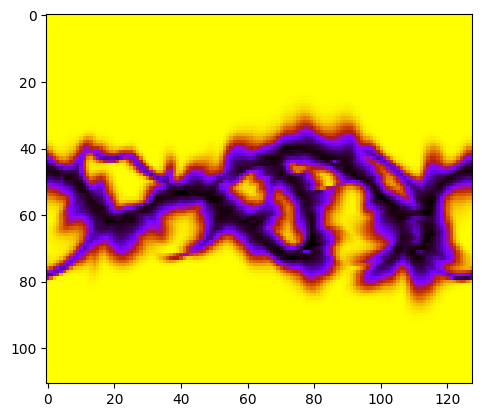

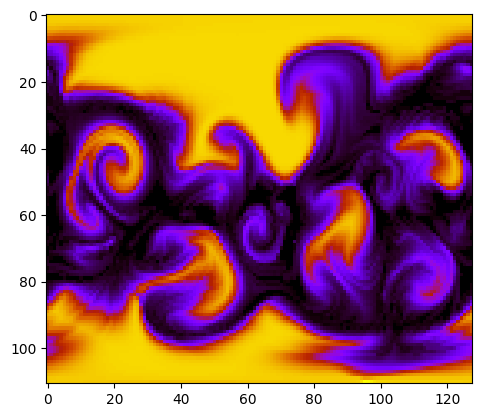

In [10]:
for III in range(len(dataset)):
    plt.imshow(dataset[III]["vx"][0], cmap='gnuplot')
    plt.show()
    # print(dataset[III]["vx"], III)

In [11]:
len(dataset)

2

In [12]:
I = 1
vx, vy, jx, jy = dataset[I]["vx"], dataset[I]["vy"], dataset[I]["jx"], dataset[I]["jy"]

print(vx.shape, vy.shape, jx.shape, jy.shape)

vx = vx.unsqueeze(1).to(device)
jx = jx.unsqueeze(1).to(device)

print(vx.shape, jx.shape)

preds = []

for i, model in enumerate(tqdm(models)):
    with torch.no_grad():
        vpred, jpred = model([vx, jx])
    preds.append([vpred, jpred])

torch.Size([1, 111, 128]) torch.Size([139, 111, 128]) torch.Size([1, 111, 128]) torch.Size([139, 111, 128])
torch.Size([1, 1, 111, 128]) torch.Size([1, 1, 111, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.09it/s]


In [13]:
vpred.shape, jpred.shape

(torch.Size([1, 139, 111, 128]), torch.Size([1, 139, 111, 128]))

In [14]:
vy = vy * (cfgs[0]["v_max"] - cfgs[0]["v_min"]) + cfgs[0]["v_min"]
vy *= 481.3711

radii, _, _ = dataset.get_grid_points()
radii = np.broadcast_to(radii[:, np.newaxis, np.newaxis], (140, 111, 128))[1:, :, :]
jy = jy * (cfgs[0]["j_max"] - cfgs[0]["j_min"]) + cfgs[0]["j_min"]
jy = jy / (radii**2)
jy = jy * 2.52 * 1e-7

for i in range(len(preds)):
    preds[i][0] = preds[i][0] * (cfgs[i]["v_max"] - cfgs[i]["v_min"]) + cfgs[i]["v_min"]
    preds[i][0] *= 481.3711

    preds[i][1] = (
        preds[i][1] * (cfgs[i]["j_max"] - cfgs[i]["j_min"]) + cfgs[i]["j_min"]
    )
    preds[i][1] = preds[i][1] / (radii**2)
    preds[i][1] = preds[i][1] * 2.52 * 1e-7

In [15]:
modality = 0
mas = [vy, jy][modality]
subplot_titles = [f'$km/s$', f'$A/m^2$']

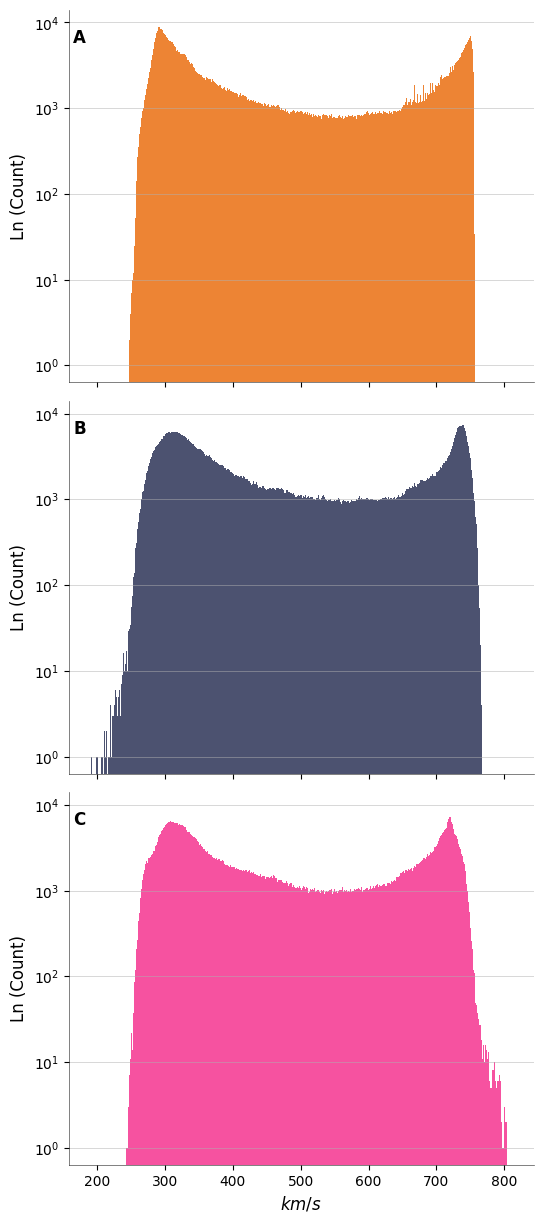

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(6, 15), sharey=True, sharex=True)
colors = ['#ed8434','#4c5270', '#f652a0']
labels = ['A', 'B', 'C']

noatt = preds[0][modality]
att = preds[1][modality]

for i, data in enumerate([mas, noatt, att]):
    ax[i].hist(data.flatten(), bins=1000, log=True, color=colors[i])
    ax[i].yaxis.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)

    ax[i].set_yticks([1, 10, 100, 1000, 10000])

    ax[i].tick_params(axis='y', which='minor', left=False)
    ax[i].minorticks_off()

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    ax[i].spines['bottom'].set_linewidth(0.5)
    ax[i].spines['bottom'].set_alpha(0.7)

    ax[i].spines['left'].set_linewidth(0.5)
    ax[i].spines['left'].set_alpha(0.7)
    
    ax[i].tick_params(axis='y', labelsize=10)  # or any size you prefer
    ax[i].tick_params(axis='x', labelsize=10)  # or any size you prefer
    
    ax[i].set_ylabel('Ln (Count)', fontsize=12)
    if i == len(colors) - 1:    
        ax[i].set_xlabel(subplot_titles[modality], fontsize=12)
        
    ax[i].text(0.01, 0.95, labels[i], transform=ax[i].transAxes,
               fontsize=12, fontweight='bold', va='top', ha='left')
plt.subplots_adjust(wspace=0, hspace=0.05)  # or even 0.01
plt.savefig('dist.pdf', format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [17]:
model_ix = 1

In [18]:
vmin = min(
    vy.min(),
    preds[model_ix][0].min()
)
vmax = max(
    vy.max(),
    preds[model_ix][0].max()
)
jmin = min(
    jy.min(),
    preds[model_ix][1].min()
)
jmax = max(
    jy.max(),
    preds[model_ix][1].max()
)


v_error = torch.abs(preds[0][0][0] - vy)
j_error = torch.abs(preds[0][1][0] - jy)

min_v_error, max_v_error = v_error.min(), v_error.max()
min_j_error, max_j_error = j_error.min(), j_error.max()

frames = []
for i in trange(vy.shape[0]):

    plt.rcParams["figure.figsize"] = [24, 12]  # default fig size.
    extent = [0, 360, -1, 1]

    fig, ax = plt.subplots(nrows=2, ncols=3, constrained_layout=True, sharey=True)

    # print(ax)
    # plt.title("hi")

    # # Plot first subplot
    im1 = ax[0, 0].imshow(
       vy[i], cmap='gnuplot', vmin=vmin, vmax=vmax, aspect="auto", origin="lower", extent=extent
    )
    ax[0, 0].set_title(f"$v_r$ MAS (Ground Truth) at {i+1}th Radius", fontsize=20)
    ax[0, 0].set_ylabel("Sin(Lat.)", fontsize=20)
    ax[0, 0].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
    ax[0, 0].set_xlabel("Longitude ($^{\circ}$)", fontsize=20)
    ax[0, 0].set_xticks(ticks=[0, 90, 180, 270, 360])
    
    # Plot second subplot
    im2 = ax[0, 1].imshow(
        preds[model_ix][0][0, i],
        cmap='gnuplot',
        vmin=vmin,
        vmax=vmax,
        aspect="auto",
        origin="lower",
        extent=extent,
    )
    ax[0, 1].set_title(f'$v_r$ SFNO-{cfgs[0]["n_layers"]}x{cfgs[0]["hidden_channels"]}-Encoder:{cfgs[0]["encoder_hidden_channels"]}', fontsize=20)
    ax[0, 1].set_xlabel("Longitude ($^{\circ}$)", fontsize=20)
    ax[0, 1].set_xticks(ticks=[0, 90, 180, 270, 360])
    
    
    # Plot second subplot
    im3 = ax[0, 2].imshow(
        v_error[i],
        vmin=min_v_error,
        vmax=max_v_error,
        cmap='grey',
        aspect="auto",
        origin="lower",
        extent=extent,
    )
    ax[0, 2].set_title(f"MAE$", fontsize=20)
    ax[0, 2].set_xlabel("Longitude ($^{\circ}$)", fontsize=20)
    ax[0, 2].set_xticks(ticks=[0, 90, 180, 270, 360])
    
    
    im4 = ax[1, 0].imshow(
       jy[i], cmap='seismic', vmin=jmin, vmax=jmax, aspect="auto", origin="lower", extent=extent
    )
    ax[1, 0].set_title(f"$J_r$ MAS (Ground Truth) at {i+1}th Radius", fontsize=20)
    ax[1, 0].set_ylabel("Sin(Lat.)", fontsize=20)
    ax[1, 0].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
    ax[1, 0].set_xlabel("Longitude ($^{\circ}$)", fontsize=20)
    ax[1, 0].set_xticks(ticks=[0, 90, 180, 270, 360])
    
    # Plot second subplot
    im5 = ax[1, 1].imshow(
        preds[model_ix][1][0, i],
        cmap='seismic',
        vmin=jmin,
        vmax=jmax,
        aspect="auto",
        origin="lower",
        extent=extent,
    )
    ax[1, 1].set_title(f'$J_r$ SFNO-{cfgs[0]["n_layers"]}x{cfgs[0]["hidden_channels"]}-Encoder:{cfgs[0]["encoder_hidden_channels"]}', fontsize=20)
    ax[1, 1].set_xlabel("Longitude ($^{\circ}$)", fontsize=20)
    ax[1, 1].set_xticks(ticks=[0, 90, 180, 270, 360])
    
    # Plot second subplot
    im6 = ax[1, 2].imshow(
        j_error[i],
        vmin=min_j_error,
        vmax=max_j_error,
        cmap='grey',
        aspect="auto",
        origin="lower",
        extent=extent,
    )
    ax[1, 2].set_title(f"MAE$", fontsize=20)
    ax[1, 2].set_xlabel("Longitude ($^{\circ}$)", fontsize=20)
    ax[1, 2].set_xticks(ticks=[0, 90, 180, 270, 360])


    cbar = fig.colorbar(im1, ax=ax, orientation="horizontal", fraction=0.1, pad=0.02)
    cbar.set_label("$km/s$", fontsize="15", rotation=360, labelpad=5)
    
    cbar = fig.colorbar(im5, ax=ax, orientation="horizontal", fraction=0.1, pad=0.02)
    cbar.set_label("$A / m^2$", fontsize="15", rotation=360, labelpad=5)
    
    cbar3 = fig.colorbar(im3, ax=ax[0, 2], orientation="vertical", fraction=0.046, pad=0.04)
    cbar3.set_label("MAE", fontsize=15)

    cbar4 = fig.colorbar(im6, ax=ax[1, 2], orientation="vertical", fraction=0.046, pad=0.04)
    cbar4.set_label("MAE", fontsize=15)

    # plt.tight_layout()
    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0.0)
    frames.append(imageio.imread(buf))
    plt.close()

100%|██████████| 139/139 [01:48<00:00,  1.28it/s]


In [19]:
output_filename = f"{str(I) +'-no att' if model_ix == 0 else '-att'}.gif"
fps = 10  # Adjust frames per second as needed

# Create video directly from frames in memory
with imageio.get_writer(output_filename, fps=fps, loop=0) as writer:
    for frame in frames:
        writer.append_data(frame)

In [23]:
modality = 1
mas = [vy, jy][modality]
subplot_titles = [f'$km/s$', f'$A/m^2$']

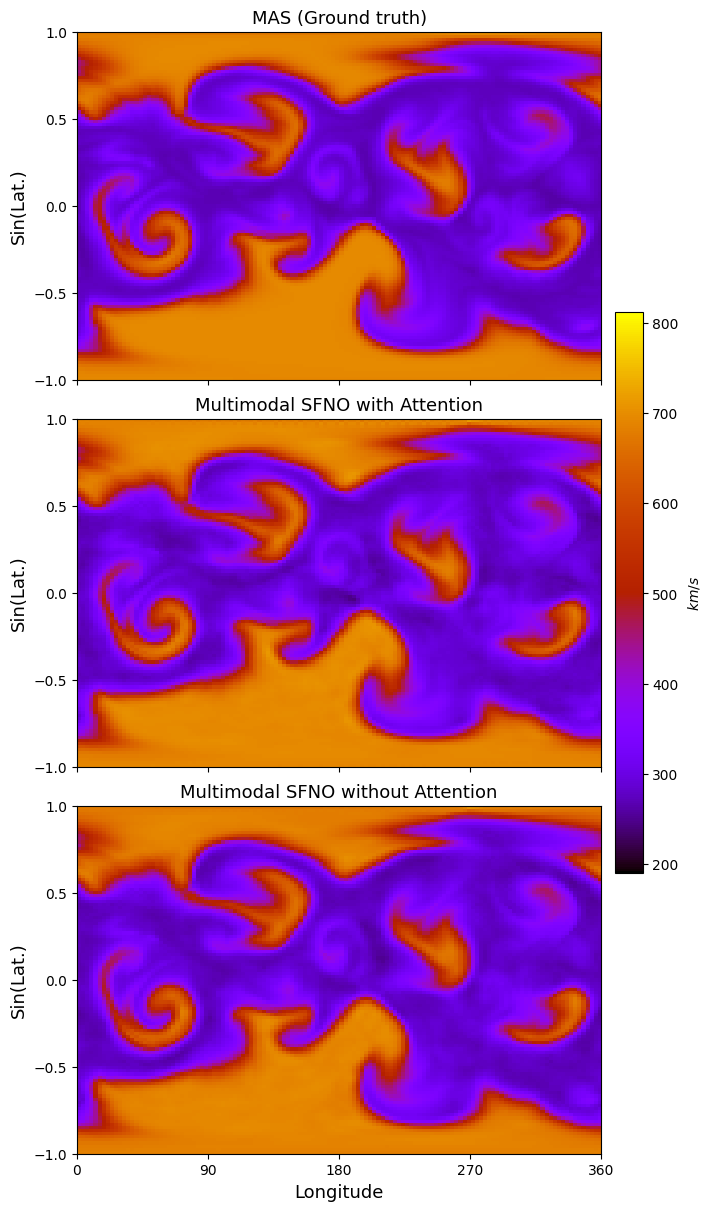

In [18]:
cube = mas.numpy()
noatt = preds[0][modality]
att = preds[1][modality]

vmin = min(
    vy.min(),
    att.min(),
    noatt.min()
)
vmax = max(
    cube.max(),
    att.max(),
    noatt.max()
)

cmap=['gnuplot', 'seismic'][modality]

slice = 10

plt.rcParams['figure.figsize'] = [7, 12]
extent = [0, 360, -1, 1]

fig, ax = plt.subplots(nrows=3, ncols=1, constrained_layout=True, sharex=True)


ax[0].set_title(f"MAS (Ground truth)", fontsize=13)
ax[0].set_ylabel("Sin(Lat.)", fontsize=13)
ax[0].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
_ = im = ax[0].imshow(cube[slice], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)


ax[1].set_title(f"Multimodal SFNO with Attention", fontsize=13)
ax[1].set_ylabel("Sin(Lat.)", fontsize=13)
ax[1].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[1].imshow(noatt[0, slice, :, :], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)


ax[2].set_title(f"Multimodal SFNO without Attention", fontsize=13)
ax[2].set_ylabel("Sin(Lat.)", fontsize=13)
ax[2].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[2].set_xticks(ticks=[0, 90, 180, 270, 360])
ax[2].set_xlabel("Longitude", fontsize=13)
_ = im = ax[2].imshow(att[0, slice, :, :], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)



cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0, shrink=0.5)
cbar.set_label(subplot_titles[modality], fontsize='10', labelpad=5)

# labels = ['A', 'B', 'C', 'D', 'E', 'F']
# for i, axis in enumerate(ax):
#     axis.text(0.99, 0.97, labels[i], transform=axis.transAxes,
#               fontsize=19, fontweight='bold', va='top', ha='right', color='black')

plt.savefig(f'{model_ix}_{slice}_{modality}' + '.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

In [53]:
radii[slice]

array([[46.338562, 46.338562, 46.338562, ..., 46.338562, 46.338562,
        46.338562],
       [46.338562, 46.338562, 46.338562, ..., 46.338562, 46.338562,
        46.338562],
       [46.338562, 46.338562, 46.338562, ..., 46.338562, 46.338562,
        46.338562],
       ...,
       [46.338562, 46.338562, 46.338562, ..., 46.338562, 46.338562,
        46.338562],
       [46.338562, 46.338562, 46.338562, ..., 46.338562, 46.338562,
        46.338562],
       [46.338562, 46.338562, 46.338562, ..., 46.338562, 46.338562,
        46.338562]], dtype=float32)

In [44]:
# cmap='gnuplot'

# slice = 13

# plt.rcParams['figure.figsize'] = [7, 12] # default fig size.
# extent = [0, 360, -1, 1]

# fig, ax = plt.subplots(nrows=4, ncols=1, constrained_layout=True, sharex=True)

# # ax[0].set_ylim(-1, 1)
# # ax[0].set_xlim(0, 360)
# ax[0].set_title("R = 30 $R_{\odot}$", fontsize=13)
# ax[0].set_ylabel("Sin(Lat.)", fontsize=13)
# ax[0].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# # ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])
# _ = im = ax[0].imshow(cube[0], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)


# # ax[1].set_ylim(-1, 1)
# # ax[1].set_xlim(0, 360)
# ax[1].set_title(f"R $\\approx${round(hux_dataset[I]['x']['r'][slice].value)}" + " $R_{\odot}$ MAS model", fontsize=13)
# ax[1].set_ylabel("Sin(Lat.)", fontsize=13)
# ax[1].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# # ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
# _ = im = ax[1].imshow(cube[slice], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)


# # ax[2].set_ylim(-1, 1)
# # ax[2].set_xlim(0, 360)
# ax[2].set_title(f"R $\\approx$ {round(hux_dataset[I]['x']['r'][slice].value)}" + " $R_{\odot}$ $10$-Channel $8 \\times 256$ SFNO model ", fontsize=14)
# ax[2].set_ylabel("Sin(Lat.)", fontsize=13)
# # ax[2].set_xlabel("Longitude ($^{\circ}$)", fontsize=13)
# ax[2].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# ax[2].set_xticks(ticks=[0, 90, 180, 270, 360])
# _ = im = ax[2].imshow(yhats[slice, :, :], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)



# # ax[2].set_ylim(-1, 1)
# # ax[2].set_xlim(0, 360)
# ax[3].set_title(f"R $\\approx$ {round(hux_dataset[I]['x']['r'][slice].value)}" + " $R_{\odot}$ HUX-f method", fontsize=13)
# ax[3].set_ylabel("Sin(Lat.)", fontsize=13)
# ax[3].set_xlabel("Longitude ($^{\circ}$)", fontsize=13)
# ax[3].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# ax[3].set_xticks(ticks=[0, 90, 180, 270, 360])
# _ = im = ax[3].imshow(hux[slice, :, :], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)

# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label('$\dfrac{km}{s}$', fontsize='10', rotation=360, labelpad=5)
# # plt.savefig('full.png')
# plt.show()

In [ ]:
7 / 12

0.5833333333333334

In [ ]:
# cmap='gnuplot'

# slice = -1

# plt.rcParams['figure.figsize'] = [7, 12] # default fig size.
# extent = [0, 360, -1, 1]

# fig, ax = plt.subplots(nrows=6, ncols=1, constrained_layout=True, sharex=True)

# # # ax[0].set_ylim(-1, 1)
# # # ax[0].set_xlim(0, 360)
# # ax[0].set_title("R = 30 $R_{\odot}$", fontsize=13)
# # ax[0].set_ylabel("Sin(Lat.)", fontsize=13)
# # ax[0].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# # # ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])
# # _ = im = ax[0].imshow(cube[0], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)


# # ax[1].set_ylim(-1, 1)
# # ax[1].set_xlim(0, 360)
# ax[0].set_title(f"MAS (Ground truth)", fontsize=13)
# ax[0].set_ylabel("Sin(Lat.)", fontsize=13)
# ax[0].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# # ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
# _ = im = ax[0].imshow(cube[slice], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)


# # ax[2].set_ylim(-1, 1)
# # ax[2].set_xlim(0, 360)
# ax[1].set_title(f"HUX-f (Baseline)", fontsize=13)
# ax[1].set_ylabel("Sin(Lat.)", fontsize=13)
# ax[1].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
# _ = im = ax[1].imshow(hux[slice, :, :], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)

# # ax[2].set_ylim(-1, 1)
# # ax[2].set_xlim(0, 360)
# ax[2].set_title(f"5-Radius SFNO (Our winning model)", fontsize=13)
# ax[2].set_ylabel("Sin(Lat.)", fontsize=13)
# # ax[2].set_xlabel("Longitude ($^{\circ}$)", fontsize=13)
# ax[2].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# ax[2].set_xticks(ticks=[0, 90, 180, 270, 360])
# _ = im = ax[2].imshow(preds[-1][slice, :, :], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)



# # ax[2].set_ylim(-1, 1)
# # ax[2].set_xlim(0, 360)
# ax[3].set_title(f"{cfgs[-2]['buffer']}-Radius SFNO", fontsize=13)
# ax[3].set_ylabel("Sin(Lat.)", fontsize=13)
# # ax[2].set_xlabel("Longitude ($^{\circ}$)", fontsize=13)
# ax[3].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# ax[3].set_xticks(ticks=[0, 90, 180, 270, 360])
# _ = im = ax[3].imshow(preds[-2][slice, :, :], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)



# # ax[2].set_ylim(-1, 1)
# # ax[2].set_xlim(0, 360)
# ax[4].set_title(f"{cfgs[-3]['buffer']}-Radius SFNO", fontsize=13)
# ax[4].set_ylabel("Sin(Lat.)", fontsize=13)
# # ax[2].set_xlabel("Longitude ($^{\circ}$)", fontsize=13)
# ax[4].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# ax[4].set_xticks(ticks=[0, 90, 180, 270, 360])
# _ = im = ax[4].imshow(preds[-3][slice, :, :], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)



# # ax[2].set_ylim(-1, 1)
# # ax[2].set_xlim(0, 360)
# ax[5].set_title(f"139-Radius SFNO", fontsize=13)
# ax[5].set_ylabel("Sin(Lat.)", fontsize=13)
# ax[5].set_xlabel("Longitude ($^{\circ}$)", fontsize=13)
# ax[5].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# ax[5].set_xticks(ticks=[0, 90, 180, 270, 360])
# _ = im = ax[5].imshow(preds[-4][slice, :, :], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)



# cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0, shrink=0.5)
# cbar.set_label('$km/s$', fontsize='10', labelpad=5)

# labels = ['A', 'B', 'C', 'D', 'E', 'F']
# # for i, axis in enumerate(ax):
#     # axis.text(0.48, 0.04, labels[i], transform=axis.transAxes,
#     #           fontsize=12, fontweight='bold', va='bottom', ha='left')
# for i, axis in enumerate(ax):
#     axis.text(0.99, 0.97, labels[i], transform=axis.transAxes,
#               fontsize=19, fontweight='bold', va='top', ha='right', color='black')
#     # axis.text(0.99, 0.95, labels[i], transform=axis.transAxes,
#     #           fontsize=12, fontweight='bold', va='top', ha='right', color='white')

# plt.savefig(path.split('/')[-2] + '-' + path.split('/')[-1] + '.pdf', bbox_inches='tight', pad_inches=0.0)
# plt.show()

In [ ]:
# cmap='gray'

# slice = -1

# plt.rcParams['figure.figsize'] = [7, 10] # default fig size.
# extent = [0, 360, -1, 1]

# fig, ax = plt.subplots(nrows=5, ncols=1, constrained_layout=True, sharex=True)

# # # ax[0].set_ylim(-1, 1)
# # # ax[0].set_xlim(0, 360)
# # ax[0].set_title("R = 30 $R_{\odot}$", fontsize=13)
# # ax[0].set_ylabel("Sin(Lat.)", fontsize=13)
# # ax[0].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# # # ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])
# # _ = im = ax[0].imshow(cube[0], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)

# error_sfno_5 = np.abs(preds[3][slice, :, :] - cube[slice].numpy())
# error_sfno_10 = np.abs(preds[2][slice, :, :] - cube[slice].numpy())
# error_sfno_20 = np.abs(preds[1][slice, :, :] - cube[slice].numpy())
# error_sfno_139 = np.abs(preds[0][slice, :, :] - cube[slice].numpy())
# error_hux = np.abs(hux[slice, :, :] - cube[slice].numpy())

# v_min_err = min(error_sfno_5.min(), error_sfno_10.min(), error_sfno_20.min(), error_hux.min(), error_sfno_139.min())
# v_max_err = max(error_sfno_5.max(), error_sfno_10.max(), error_sfno_20.max(), error_hux.max(), error_sfno_139.min())

# # ax[1].set_ylim(-1, 1)
# # ax[1].set_xlim(0, 360)
# ax[4].set_title(f"139-Radius SFNO MAE", fontsize=13)
# ax[4].set_ylabel("Sin(Lat.)", fontsize=13)
# ax[4].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# # ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
# _ = im = ax[4].imshow(error_sfno_139, cmap=cmap, vmin=v_min_err, vmax=v_max_err, aspect='auto', origin='lower', extent=extent)

# ax[3].set_title(f"20-Radius SFNO MAE", fontsize=13)
# ax[3].set_ylabel("Sin(Lat.)", fontsize=13)
# ax[3].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# # ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
# _ = im = ax[3].imshow(error_sfno_20, cmap=cmap, vmin=v_min_err, vmax=v_max_err, aspect='auto', origin='lower', extent=extent)

# # ax[1].set_ylim(-1, 1)
# # ax[1].set_xlim(0, 360)
# ax[2].set_title(f"10-Radius SFNO MAE", fontsize=13)
# ax[2].set_ylabel("Sin(Lat.)", fontsize=13)
# ax[2].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# # ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
# _ = im = ax[2].imshow(error_sfno_10, cmap=cmap, vmin=v_min_err, vmax=v_max_err, aspect='auto', origin='lower', extent=extent)

# ax[1].set_title(f"5-Radius SFNO (Our winning model) MAE", fontsize=13)
# ax[1].set_ylabel("Sin(Lat.)", fontsize=13)
# ax[1].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# # ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
# _ = im = ax[1].imshow(error_sfno_5, cmap=cmap, vmin=v_min_err, vmax=v_max_err, aspect='auto', origin='lower', extent=extent)

# # # ax[1].set_ylim(-1, 1)
# # # ax[1].set_xlim(0, 360)
# # ax[2].set_title(f"139-Radius SFNO MAE", fontsize=13)
# # ax[2].set_ylabel("Sin(Lat.)", fontsize=13)
# # ax[2].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# # # ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
# # _ = im = ax[2].imshow(error_sfno_139, cmap=cmap, vmin=v_min_err, vmax=v_max_err, aspect='auto', origin='lower', extent=extent)


# # ax[2].set_ylim(-1, 1)
# # ax[2].set_xlim(0, 360)
# ax[0].set_title(f"HUX-f (Baseline) MAE", fontsize=13)
# ax[0].set_ylabel("Sin(Lat.)", fontsize=13)
# ax[0].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])
# _ = im = ax[0].imshow(error_hux, cmap=cmap, vmin=v_min_err, vmax=v_max_err, aspect='auto', origin='lower', extent=extent)

# # # ax[2].set_ylim(-1, 1)
# # # ax[2].set_xlim(0, 360)
# # ax[2].set_title(f"5-Radius SFNO (Our optimal model)", fontsize=13)
# # ax[2].set_ylabel("Sin(Lat.)", fontsize=13)
# # # ax[2].set_xlabel("Longitude ($^{\circ}$)", fontsize=13)
# # ax[2].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# # ax[2].set_xticks(ticks=[0, 90, 180, 270, 360])
# # _ = im = ax[2].imshow(preds[-1][slice, :, :], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)



# # # ax[2].set_ylim(-1, 1)
# # # ax[2].set_xlim(0, 360)
# # ax[3].set_title(f"{cfgs[-2]['buffer']}-Radius SFNO", fontsize=13)
# # ax[3].set_ylabel("Sin(Lat.)", fontsize=13)
# # # ax[2].set_xlabel("Longitude ($^{\circ}$)", fontsize=13)
# # ax[3].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# # ax[3].set_xticks(ticks=[0, 90, 180, 270, 360])
# # _ = im = ax[3].imshow(preds[-2][slice, :, :], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)



# # # ax[2].set_ylim(-1, 1)
# # # ax[2].set_xlim(0, 360)
# # ax[4].set_title(f"{cfgs[-3]['buffer']}-Radius SFNO", fontsize=13)
# # ax[4].set_ylabel("Sin(Lat.)", fontsize=13)
# # # ax[2].set_xlabel("Longitude ($^{\circ}$)", fontsize=13)
# # ax[4].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# # ax[4].set_xticks(ticks=[0, 90, 180, 270, 360])
# # _ = im = ax[4].imshow(preds[-3][slice, :, :], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)



# # # ax[2].set_ylim(-1, 1)
# # # ax[2].set_xlim(0, 360)
# # ax[5].set_title(f"139-Radius SFNO", fontsize=13)
# # ax[5].set_ylabel("Sin(Lat.)", fontsize=13)
# # ax[5].set_xlabel("Longitude ($^{\circ}$)", fontsize=13)
# # ax[5].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
# # ax[5].set_xticks(ticks=[0, 90, 180, 270, 360])
# # _ = im = ax[5].imshow(preds[-4][slice, :, :], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='lower', extent=extent)



# cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0, shrink=0.5)
# cbar.set_label('$km/s$', fontsize='10', labelpad=5)

# labels = ['A', 'B', 'C', 'D', 'E', 'F']
# # for i, axis in enumerate(ax):
#     # axis.text(0.48, 0.04, labels[i], transform=axis.transAxes,
#     #           fontsize=12, fontweight='bold', va='bottom', ha='left')
# for i, axis in enumerate(ax):
#     axis.text(0.99, 0.97, labels[i], transform=axis.transAxes,
#               fontsize=19, fontweight='bold', va='top', ha='right', color='white')
#     # axis.text(0.99, 0.95, labels[i], transform=axis.transAxes,
#     #           fontsize=12, fontweight='bold', va='top', ha='right', color='white')

# plt.savefig('err_' + path.split('/')[-2] + '-' + path.split('/')[-1] + '.pdf', bbox_inches='tight', pad_inches=0.0)
# plt.show()

In [ ]:
# print(v_min_err, v_max_err)

In [ ]:
# import numpy as np
# import pyvista as pv

# # Shape: (r, theta, phi)
# data = cube[-10:, :, :].numpy()

# r = np.linspace(1, 2, 10)  # radial extent from 1 to 2 units (adjust as needed)
# theta = np.linspace(0, np.pi, 111)  # latitude: 0 to pi
# phi = np.linspace(0, 2*np.pi, 128)  # longitude: 0 to 2pi

# # Create meshgrid
# r3d, theta3d, phi3d = np.meshgrid(r, theta, phi, indexing='ij')

# # Convert to Cartesian coordinates
# x = r3d * np.sin(theta3d) * np.cos(phi3d)
# y = r3d * np.sin(theta3d) * np.sin(phi3d)
# z = r3d * np.cos(theta3d)

# # Flatten the arrays
# points = np.c_[x.ravel(), y.ravel(), z.ravel()]
# values = data.ravel(order='C')

# # Create a structured grid
# grid = pv.StructuredGrid()
# grid.points = points
# grid.dimensions = data.shape[::-1]  # reverse for (phi, theta, r)

# # Attach scalar field
# grid["values"] = values

# # Plot
# plotter = pv.Plotter()
# plotter.add_volume(grid, scalars="values", opacity="sigmoid", cmap="gnuplot")
# plotter.show()


In [ ]:
# def resize_3d(array, new_height, new_width):
#     resized_array = np.zeros((array.shape[0], new_height, new_width))

#     for i in range(array.shape[0]):
#         resized_array[i] = cv.resize(
#             array[i], (new_width, new_height), interpolation=cv.INTER_LINEAR
#         )

#     return resized_array

In [ ]:
# I = 3
# instance, path = dataset[I]

# preds = []

# sizes = [(55, 128)]
# for size in sizes:
#     data = torch.tensor(resize_3d(instance.numpy(), size[0], size[1]), dtype=torch.float)

#     cube = data.unsqueeze(0)  # add batch dimension
#     pred = []

#     with torch.no_grad():
#         # t = cube.shape[1] - 1
#         # x = cube[:, 0:1, :, :].to(device)
#         # y = cube[:, 1 : buffer + 1, :, :].to(device)

#         # pred_buf = model(x)
#         # pred.append(pred_buf)

#         # for i in trange(buffer - 1, t - 1, buffer, leave=False):
#         #     x = pred_buf[:, -1:, :, :].to(device)
#         #     pred_buf = model(x)
#         #     pred.append(pred_buf)

#         # pred = torch.cat(pred, dim=1).squeeze(2)
#         # yhats = pred[:, :t, :, :]
#         # y = cube[0, 1:, :, :].to(device)
#         t = cube.shape[1]  # 140
#         x = cube[:, 0:1, :, :].to(device)  # initial input
#         yhats = []

#         # Step through time autoregressively
#         for i in trange(0, t - 1, buffer, leave=False):
#             y_start = i + 1
#             y_end = min(i + buffer + 1, t)

#             y = cube[:, y_start:y_end, :, :].to(device)  # target: ground truth next slices
            
#             # print(y_start, y_end, y.shape)
#             pred_buf = model(x)[:, :y.shape[1], :, :]                          # model predicts next <buffer> steps

#             yhats.append(pred_buf)

#             # next input is last predicted frame (1-step only)
#             x = pred_buf[:, -1:, :, :].detach()
#             x = x.to(cube.dtype)

#         # stack predictions and evaluate full metrics
#         yhats = torch.cat(yhats, dim=1)  # shape (B, T-1, H, W)
#         y = cube[:, 1:, :, :].to(device)
        
#     print(path)

#     y = y[0]
#     yhats = yhats[0]

#     yhats = yhats * (cfg["v_max"] - cfg["v_min"]) + cfg["v_min"]

#     yhats *= 481.3711

#     preds.append(yhats)

In [ ]:
# I = 0

# data, Radii = preds[I].numpy(), np.load('/Users/reza/Career/DMLab/SURROGATE/sun-sim/src/sfno/mhd/vr/clean/Radii.npy')

# print(data.shape)

# # Angular resolution
# n_theta = data.shape[1]
# n_phi = data.shape[2]

# # Create angular grids
# theta = np.linspace(0, np.pi, n_theta)  # [0, π]
# phi = np.linspace(0, 2 * np.pi, n_phi)  # [0, 2π]
# theta, phi = np.meshgrid(theta, phi, indexing='ij')  # shape [128, 111]

# # Set up 3D plot
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_box_aspect([1, 1, 1])
# ax.axis("off")

# # Plot each spherical surface
# i = 10
# rotate = 120

# r = Radii[i]
# rot = 10

# # Set up 3D plot
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# # for i, r in enumerate(Radii[:10]):
# # Spherical to Cartesian
# d = data[i]  # shape [128, 111]
# # d = d.transpose((1, 0))
# # print(d.shape)
# d = np.concatenate((d[rot:, :], d[:rot, :]), axis=0)
# x = r * np.sin(theta) * np.cos(phi)
# y = r * np.sin(theta) * np.sin(phi)
# z = r * np.cos(theta)

# # alpha = 1 - (r / Radii[-1]) + 0.1
# # Plot surface
# ax.plot_surface(
#     x, y, z,
#     facecolors=plt.cm.gnuplot((d - data.min()) / (data.max() - data.min())),
#     rstride=1, cstride=1, antialiased=True, shade=False, #alpha=0.1
# )

# # Remove all axes, padding, whitespace
# ax.set_box_aspect([1, 1, 1])
# ax.set_axis_off()
# ax.grid(False)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])

# # Remove margins
# plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

# # Save
# fig.savefig(f"{sizes[I]}.png", format='png', bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Load the data
# df = pd.read_csv('/Users/reza/Career/DMLab/SURROGATE/Data/13-month-sunspot-count.csv', sep=';', header=None)
# df.columns = ['Year', 'Month', 'DecimalYear', 'SmoothedSunspotNumber', 'StdDev', 'Observations', 'Flag']

# # Filter the desired range
# start = 2015.83125
# end = 2025.01664
# df_filtered = df[(df['DecimalYear'] >= start) & (df['DecimalYear'] <= end)]

# year_ticks = np.arange(2016, 2026)  # 2016 to 2025 inclusive

# # Plot
# plt.figure(figsize=(10, 4))
# plt.plot(df_filtered['DecimalYear'], df_filtered['SmoothedSunspotNumber'], color='darkred')
# plt.xlabel('Year')
# plt.ylabel('Smoothed Sunspot Number')
# # plt.title('13-month Smoothed Sunspot Number (2015.83–2025.02)')
# plt.xticks(year_ticks)
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [ ]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.lines import Line2D
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# import re

# # Load and filter sunspot data
# sunspot = pd.read_csv(
#     "/Users/reza/Career/DMLab/SURROGATE/Data/13-month-sunspot-count.csv",
#     sep=";",
#     header=None,
# )
# sunspot.columns = [
#     "Year",
#     "Month",
#     "DecimalYear",
#     "SmoothedSunspotNumber",
#     "StdDev",
#     "Observations",
#     "Flag",
# ]
# sunspot = sunspot[
#     (sunspot["DecimalYear"] >= 2015.83125) & (sunspot["DecimalYear"] <= 2025.01664)
# ].reset_index(drop=True)
# x = sunspot["DecimalYear"]

# # Normalize helper
# normalize = lambda s: (s - s.min()) / (s.max() - s.min())

# # Load model error data
# modelA = pd.read_csv(
#     "/Users/reza/Career/DMLab/SURROGATE/results/sfno/exp_44/evaluation_mse.csv"
# )
# modelB = pd.read_csv(
#     "/Users/reza/Career/DMLab/SURROGATE/results/sfno/hux/hux_evaluation_mse.csv"
# )

# # Extract Carrington rotations from modelA path
# modelA["cr"] = modelA["path"].apply(lambda p: re.search(r"cr(\d+)", p).group(0))  # e.g., 'cr2170'

# # Keep only the first instrument per CR
# modelA_unique = modelA.groupby("cr", sort=True).first().reset_index()

# # Use the same indices to subset modelB
# modelB_aligned = modelB.iloc[modelA_unique.index].reset_index(drop=True)

# # Normalize errors independently
# mse_a = normalize(modelA_unique["mse"])
# mse_b = normalize(modelB_aligned["mse"])
# masked_a = normalize(modelA_unique["masked_mse"])
# masked_b = normalize(modelB_aligned["masked_mse"])

# # Build evenly spaced x-axis
# start, end = x.iloc[0], x.iloc[-1]
# x_mse = np.linspace(start, end, len(mse_a))

# # Plotting
# fig, axs = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

# # # MSE subplot
# # axs[0].plot(x_mse, mse_a, label="Model A", color="#4c5270", alpha=0.7)
# # axs[0].plot(x_mse, mse_b, label="Model B", color="#f652a0", alpha=0.7)
# # axs[0].set_ylabel("MSE (Norm. Indept.)", fontsize=12)# (normalized independently)")
# # axs[0].grid(True)

# # # Masked MSE subplot
# # axs[1].plot(x_mse, masked_a, label="Model A (Masked)", color="#4c5270", alpha=0.7)
# # axs[1].plot(x_mse, masked_b, label="Model B (Masked)", color="#f652a0", alpha=0.7)
# # axs[1].set_ylabel("Edge MSE (Norm. Indept.)", fontsize=12)# (normalized independently)")
# # axs[1].grid(True)

# # axs[0].scatter(x_mse, mse_a, label="Model A", color="#4c5270", alpha=0.7, s=20)
# # axs[0].scatter(x_mse, mse_b, label="Model B", color="#f652a0", alpha=0.7, s=20)
# # axs[0].set_ylabel("MSE (Norm. Indept.)", fontsize=12)
# # axs[0].grid(True)

# # # Masked MSE subplot (scatter instead of line)
# # axs[1].scatter(x_mse, masked_a, label="Model A (Masked)", color="#4c5270", alpha=0.7, s=20)
# # axs[1].scatter(x_mse, masked_b, label="Model B (Masked)", color="#f652a0", alpha=0.7, s=20)
# # axs[1].set_ylabel("Edge MSE (Norm. Indept.)", fontsize=12)
# # axs[1].grid(True)

# from scipy.interpolate import interp1d
# from scipy.signal import savgol_filter

# # Interpolate helper
# def interpolate_to_sunspot(x_src, y_src, x_target):
#     f = interp1d(x_src, y_src, kind="linear", fill_value="extrapolate")
#     return f(x_target)

# # Interpolate to sunspot timeline
# mse_a_interp = interpolate_to_sunspot(x_mse, mse_a, x)
# mse_b_interp = interpolate_to_sunspot(x_mse, mse_b, x)
# masked_a_interp = interpolate_to_sunspot(x_mse, masked_a, x)
# masked_b_interp = interpolate_to_sunspot(x_mse, masked_b, x)

# # Apply smoothing (Savitzky–Golay, similar to running mean)
# window = 15 if len(x) > 15 else len(x) - (len(x) % 2 == 0)  # must be odd
# poly = 3
# mse_a_smooth = savgol_filter(mse_a_interp, window, poly)
# mse_b_smooth = savgol_filter(mse_b_interp, window, poly)
# masked_a_smooth = savgol_filter(masked_a_interp, window, poly)
# masked_b_smooth = savgol_filter(masked_b_interp, window, poly)

# # --- plotting part ---
# # MSE subplot: scatter + smooth
# axs[0].scatter(x_mse, mse_a, label="Model A", color="#4c5270", alpha=0.6, s=18)
# axs[0].scatter(x_mse, mse_b, label="Model B", color="#f652a0", alpha=0.6, s=18)
# axs[0].plot(x, mse_a_smooth, color="#4c5270", linewidth=2.2)
# axs[0].plot(x, mse_b_smooth, color="#f652a0", linewidth=2.2)
# axs[0].set_ylabel("MSE (Norm. Indept.)", fontsize=12)
# axs[0].grid(True)

# # Masked MSE subplot: scatter + smooth
# axs[1].scatter(x_mse, masked_a, label="Model A (Masked)", color="#4c5270", alpha=0.6, s=18)
# axs[1].scatter(x_mse, masked_b, label="Model B (Masked)", color="#f652a0", alpha=0.6, s=18)
# axs[1].plot(x, masked_a_smooth, color="#4c5270", linewidth=2.2)
# axs[1].plot(x, masked_b_smooth, color="#f652a0", linewidth=2.2)
# axs[1].set_ylabel("Edge MSE (Norm. Indept.)", fontsize=12)
# axs[1].grid(True)


# # Sunspot subplot
# axs[2].plot(
#     x,
#     sunspot["SmoothedSunspotNumber"],
#     label="Smoothed Sunspot Number",
#     color="#ed8434",
#     linewidth=2
# )
# axs[2].set_xlabel("Year", fontsize=12)
# axs[2].set_ylabel("Sunspot count", fontsize=12)
# axs[2].grid(True)
# axs[2].set_xticks(np.arange(2016, 2026))

# # Create a divider for the sunspot axis and add a new axis below it
# divider = make_axes_locatable(axs[2])
# ax2 = divider.append_axes("bottom", size="1%", pad=0.5)

# # Plot an empty line to make it align properly
# ax2.plot([], [])

# # Set same limits and ticks
# ax2.set_xlim(axs[2].get_xlim())

# # Step size for readability
# step = max(1, len(x_mse) // 4)

# # Always include last CR
# tick_idxs = list(range(0, len(x_mse), step))
# if (len(x_mse) - 1) not in tick_idxs:
#     tick_idxs.append(len(x_mse) - 1)

# xticks = x_mse[tick_idxs]
# cr_numbers = modelA_unique["cr"].str.extract(r'(\d+)')[0].astype(str).iloc[tick_idxs]

# # Set tick positions and labels
# ax2.set_xticks(xticks)
# ax2.set_xticklabels(cr_numbers, rotation=0, fontsize=9)

# # Label the lower axis
# ax2.set_xlabel("Carrington Rotation", fontsize=12)

# # Hide the frame and y-axis
# ax2.yaxis.set_visible(False)
# ax2.spines["top"].set_visible(False)

# labels = ["A", "B", "C"]

# for ax, label in zip(axs, labels):
#     ax.text(
#         0.03, 0.95, label,
#         transform=ax.transAxes,
#         fontsize=25,
#         # fontweight="bold",
#         va="top",
#         ha="left"
#     )

# handles = [
#     Line2D([0], [0], color="#4c5270", label="5-Radius SFNO", alpha=1, linewidth=4),
#     Line2D([0], [0], color="#f652a0", label="HUX-f", alpha=1, linewidth=4),
#     Line2D([0], [0], color="#ed8434", label="Solar activity", alpha=1, linewidth=4),
# ]

# # Add the legend below the plots
# fig.legend(
#     handles=handles,
#     loc="lower center",
#     ncol=3,
#     frameon=False,
#     bbox_to_anchor=(0.5, -0.03),
#     fontsize=12
# )

# plt.tight_layout()
# plt.savefig('difficulty.pdf', format='pdf', bbox_inches='tight', pad_inches=0.0)
# plt.show()


In [ ]:
# modelA_unique["instrument"] = modelA_unique["path"].apply(lambda p: p.rstrip("/").split("/")[-1])

# # Print instruments used per CR
# for cr, instr in zip(modelA_unique["cr"], modelA_unique["instrument"]):
#     print(f"{cr}: {instr}")

In [ ]:
# # Find the index of max sunspot number
# peak_idx = sunspot["SmoothedSunspotNumber"].idxmax()
# peak_year = sunspot["DecimalYear"].iloc[peak_idx]

# # Find the CR index closest in time
# closest_cr_idx = np.argmin(np.abs(x_mse - peak_year))
# closest_cr = modelA_unique["cr"].iloc[closest_cr_idx]

# print(f"Peak solar activity at year {peak_year:.3f} is closest to Carrington Rotation {closest_cr}.")
